In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

In [29]:
###----------------
### Some parameters
###----------------

inpDir = './DATA/KAGGLE'
outDir = './home/dai/Downloads/Sahil/Final Project/DeepFake Audio Analyzer/KAGGLE/output'
subDir = 'Dataset'
audDir = "./DATA/KAGGLE/AUDIO"

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
ALPHA = 0.001 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

BATCH_SIZE = 26

PATIENCE = 20

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [30]:
gpus = tf.config.list_physical_devices('GPU')

try:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print (len(gpus), 'Phusical GPUs', len(logical_gpus), 'Logical GPUs')
except:
    print ('invalid device')

invalid device


In [31]:
R_data = pd.read_csv('../DATA/csvs/linus-original_REAL.csv')
R_data['LABEL'] = 'REAL'
R_data.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.291005,0.100972,1503.819020,2003.900473,2640.264338,0.058461,-227.28400,117.363870,-21.856697,-5.956208,...,0.231222,-4.286140,-0.658060,-17.671778,0.492580,-8.939298,-10.583409,-9.856175,0.110423,REAL
1,0.488654,0.005333,2757.999207,2607.776140,5640.965132,0.129239,-376.87490,82.629425,-4.113033,13.557878,...,-1.619721,-5.480615,-1.591572,-9.422898,-4.021746,-7.764452,-3.283262,-6.914111,-3.745474,REAL
2,0.320947,0.059529,1876.721927,2279.032510,3907.786976,0.085582,-284.79144,104.583750,1.505778,11.288380,...,-4.458688,-9.660798,-4.906862,-12.124472,-6.083214,-8.779160,-4.301162,-9.839105,-2.189336,REAL
3,0.317934,0.053302,2061.158776,2186.794174,3676.794434,0.099088,-258.28410,94.734474,1.924067,23.870354,...,-7.312897,-9.438956,-7.222197,-11.617744,-1.504134,-6.931713,-4.455357,-3.408775,-0.722356,REAL
4,0.392725,0.048176,2213.382506,2198.764449,4162.759677,0.132568,-307.62920,100.989970,-14.262594,8.875005,...,-2.009577,-4.004641,-5.763664,-7.626152,-1.623855,-5.220128,-1.803224,-4.053137,2.000329,REAL


In [32]:
F_data1 = pd.read_csv('../DATA/csvs/linus-to-biden_FAKE.csv')
F_data2 = pd.read_csv('../DATA/csvs/linus-to-margot_FAKE.csv')
F_data3 = pd.read_csv('../DATA/csvs/linus-to-musk_FAKE.csv')
F_data4 = pd.read_csv('../DATA/csvs/linus-to-obam_FAKE.csv')

In [33]:
F_data_train = pd.concat([F_data1,F_data2,F_data3],ignore_index=True)
F_data_train.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.291005,0.100972,1503.819020,2003.900473,2640.264338,0.058461,-227.28400,117.363870,-21.856697,-5.956208,...,0.231222,-4.286140,-0.658060,-17.671778,0.492580,-8.939298,-10.583409,-9.856175,0.110423,FAKE
1,0.488654,0.005333,2757.999207,2607.776140,5640.965132,0.129239,-376.87490,82.629425,-4.113033,13.557878,...,-1.619721,-5.480615,-1.591572,-9.422898,-4.021746,-7.764452,-3.283262,-6.914111,-3.745474,FAKE
2,0.320947,0.059529,1876.721927,2279.032510,3907.786976,0.085582,-284.79144,104.583750,1.505778,11.288380,...,-4.458688,-9.660798,-4.906862,-12.124472,-6.083214,-8.779160,-4.301162,-9.839105,-2.189336,FAKE
3,0.317934,0.053302,2061.158776,2186.794174,3676.794434,0.099088,-258.28410,94.734474,1.924067,23.870354,...,-7.312897,-9.438956,-7.222197,-11.617744,-1.504134,-6.931713,-4.455357,-3.408775,-0.722356,FAKE
4,0.392725,0.048176,2213.382506,2198.764449,4162.759677,0.132568,-307.62920,100.989970,-14.262594,8.875005,...,-2.009577,-4.004641,-5.763664,-7.626152,-1.623855,-5.220128,-1.803224,-4.053137,2.000329,FAKE


In [34]:
len(F_data_train.values) ,len(R_data.values)

(18066, 27387)

In [35]:
F_data_test = pd.read_csv('../DATA/csvs/linus-to-ryan_FAKE.csv')
len(F_data_test)

7735

In [36]:
R_data_train = R_data[:-7735]
R_data_test = R_data[-7735:]

In [37]:
R_data_train.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.291005,0.100972,1503.819020,2003.900473,2640.264338,0.058461,-227.28400,117.363870,-21.856697,-5.956208,...,0.231222,-4.286140,-0.658060,-17.671778,0.492580,-8.939298,-10.583409,-9.856175,0.110423,REAL
1,0.488654,0.005333,2757.999207,2607.776140,5640.965132,0.129239,-376.87490,82.629425,-4.113033,13.557878,...,-1.619721,-5.480615,-1.591572,-9.422898,-4.021746,-7.764452,-3.283262,-6.914111,-3.745474,REAL
2,0.320947,0.059529,1876.721927,2279.032510,3907.786976,0.085582,-284.79144,104.583750,1.505778,11.288380,...,-4.458688,-9.660798,-4.906862,-12.124472,-6.083214,-8.779160,-4.301162,-9.839105,-2.189336,REAL
3,0.317934,0.053302,2061.158776,2186.794174,3676.794434,0.099088,-258.28410,94.734474,1.924067,23.870354,...,-7.312897,-9.438956,-7.222197,-11.617744,-1.504134,-6.931713,-4.455357,-3.408775,-0.722356,REAL
4,0.392725,0.048176,2213.382506,2198.764449,4162.759677,0.132568,-307.62920,100.989970,-14.262594,8.875005,...,-2.009577,-4.004641,-5.763664,-7.626152,-1.623855,-5.220128,-1.803224,-4.053137,2.000329,REAL


In [38]:
R_data_test.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
19652,0.522520,0.001923,2927.485871,3017.747606,6492.505438,0.146240,-541.27875,80.58519,5.063529,11.811008,...,-5.780697,-8.157668,1.626856,-11.141909,3.851940,-7.839003,-7.543894,-4.211743,-2.449201,REAL
19653,0.370526,0.019954,2349.007003,1991.424779,4413.572554,0.145885,-372.88815,100.32424,-31.726295,30.779938,...,-1.726221,-2.823141,0.191182,-10.710197,4.409854,-9.961201,-5.346068,0.398414,-2.984839,REAL
19654,0.335181,0.015613,1875.206967,1752.676600,3381.446977,0.109541,-394.68094,130.56654,-20.224382,19.480278,...,-4.201188,-1.225125,1.966461,-7.710483,7.600229,-4.047335,-6.942566,-5.518033,0.793977,REAL
19655,0.325174,0.014401,1546.104725,1728.792231,2903.556685,0.071578,-395.19230,137.39280,-16.907106,25.264147,...,-3.265248,-0.420813,2.913512,-10.687929,3.544889,-4.427277,-5.745056,-5.375172,2.877640,REAL
19656,0.462701,0.006137,2839.932131,2528.630767,5570.492831,0.194436,-461.58026,95.56310,-8.653767,-1.325745,...,-0.240757,-7.263702,5.655122,-12.074467,1.189853,-4.687780,-0.612492,-5.217877,-2.754692,REAL


In [39]:
len(F_data_train.values) ,len(R_data_train.values)

(18066, 19652)

In [40]:
train_df = pd.concat([R_data_train,F_data_train],ignore_index=True)
test_df = pd.concat([R_data_test , F_data_test],ignore_index=True)

In [41]:
len(train_df) , len(test_df)

(37718, 15470)

In [42]:
train_df[train_df['LABEL'] == 'REAL'].head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.291005,0.100972,1503.819020,2003.900473,2640.264338,0.058461,-227.28400,117.363870,-21.856697,-5.956208,...,0.231222,-4.286140,-0.658060,-17.671778,0.492580,-8.939298,-10.583409,-9.856175,0.110423,REAL
1,0.488654,0.005333,2757.999207,2607.776140,5640.965132,0.129239,-376.87490,82.629425,-4.113033,13.557878,...,-1.619721,-5.480615,-1.591572,-9.422898,-4.021746,-7.764452,-3.283262,-6.914111,-3.745474,REAL
2,0.320947,0.059529,1876.721927,2279.032510,3907.786976,0.085582,-284.79144,104.583750,1.505778,11.288380,...,-4.458688,-9.660798,-4.906862,-12.124472,-6.083214,-8.779160,-4.301162,-9.839105,-2.189336,REAL
3,0.317934,0.053302,2061.158776,2186.794174,3676.794434,0.099088,-258.28410,94.734474,1.924067,23.870354,...,-7.312897,-9.438956,-7.222197,-11.617744,-1.504134,-6.931713,-4.455357,-3.408775,-0.722356,REAL
4,0.392725,0.048176,2213.382506,2198.764449,4162.759677,0.132568,-307.62920,100.989970,-14.262594,8.875005,...,-2.009577,-4.004641,-5.763664,-7.626152,-1.623855,-5.220128,-1.803224,-4.053137,2.000329,REAL


In [43]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)

In [44]:
train_df = train_df.reset_index()

In [45]:
train_df.drop(columns='index',inplace=True)
train_df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.304279,0.092886,1794.446679,1756.005675,3267.663574,0.073553,-220.75699,113.30632,-27.155550,40.468494,...,2.647593,-1.669176,-2.412218,-5.014159,4.789261,-6.480739,-5.934535,-0.648805,0.540180,FAKE
1,0.456284,0.068364,2146.716417,1894.706165,3632.749245,0.134144,-242.28125,114.65232,3.489184,21.390535,...,-4.761686,-8.131708,1.514646,-5.092492,-4.788732,-6.710684,-2.234114,-5.963158,-0.813527,REAL
2,0.385467,0.061983,2195.885111,1969.970630,4137.800737,0.122570,-297.45290,114.05494,-29.562916,8.112804,...,3.252584,-4.576847,-3.276252,-3.806370,0.747901,-4.863185,-6.573349,-3.803952,-0.913928,FAKE
3,0.368274,0.049349,2203.852925,2142.767623,4204.357910,0.110274,-284.55720,96.58345,-9.866542,36.392326,...,2.216498,-2.817403,-1.544313,-1.874629,3.594598,-11.499130,-6.965814,-0.491303,-0.708371,REAL
4,0.443575,0.027632,1574.307715,1677.112318,2834.063166,0.076394,-340.24540,140.61276,-34.598526,15.854402,...,-8.338179,-7.831413,3.264795,0.857572,-1.304414,-2.075508,-1.730636,-3.084810,-3.476430,REAL


In [46]:
from sklearn.utils import shuffle
test_df = shuffle(test_df)

In [47]:
test_df = test_df.reset_index()

In [48]:
test_df.drop(columns='index',inplace=True)
test_df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.337476,0.029032,1942.822495,1758.451077,3453.387451,0.101796,-318.75916,118.31187,-12.730703,38.510480,...,-7.240915,-4.896849,4.683724,-3.443555,-3.727466,-3.312700,-0.381709,-6.534680,-1.739277,REAL
1,0.301975,0.036451,2288.393516,2228.905024,4332.823042,0.117776,-328.45105,81.67536,-36.246807,-6.127306,...,4.607518,2.159596,2.641095,-3.599835,-12.327871,-11.009732,-5.858573,-12.919236,-3.449049,FAKE
2,0.407150,0.018913,2868.737011,2875.869705,6006.540194,0.111051,-315.02353,73.68216,26.055010,15.305374,...,9.438389,0.592112,5.220051,2.194389,-4.171344,-3.217307,6.390453,0.935533,3.519102,FAKE
3,0.411047,0.034129,1967.822135,1847.485349,3610.237260,0.107422,-329.16630,118.05694,6.110272,29.354237,...,-7.681856,-3.473124,1.323403,-10.236434,1.215809,-3.684210,-5.906889,-3.488763,-5.420478,REAL
4,0.375650,0.038981,1828.344206,1449.017094,2588.144198,0.130227,-280.06708,134.68565,-45.811764,-29.766455,...,-4.137407,0.673523,-13.098481,-19.419058,-1.534172,-14.176057,2.905927,-6.718604,-12.332290,REAL


In [49]:
# test
X_train = train_df.drop(columns='LABEL')
y_train = train_df['LABEL']

# Train
X_test = test_df.drop(columns='LABEL')
y_test = test_df['LABEL']

In [50]:
Lables= {"REAL" : 1 , "FAKE" : 0}

y_train.replace({"REAL" : 1 , "FAKE" : 0},inplace=True)

y_test.replace({"REAL" : 1 , "FAKE" : 0},inplace=True)

In [51]:
X_train = X_train[18:]
y_train = y_train[18:]

In [52]:
X_train.shape , y_train.shape , X_test.shape ,y_test.shape

((37700, 26), (37700,), (15470, 26), (15470,))

### ANN


In [53]:
tf.keras.layers.Dense?

Init signature:
tf.keras.layers.Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
Just your regular densely-connected NN layer.

`Dense` implements the operation:
`output = activation(dot(input, kernel) + bias)`
where `activation` is the element-wise activation function
passed as the `activation` argument, `kernel` is a weights matrix
created by the layer, and `bias` is a bias vector created by the layer
(only applicable if `use_bias` is `True`). These are all attributes of
`Dense`.

Note: If the input to the layer has a rank greater than 2, then `Dense`
computes the dot product between the `inputs` and the `kernel` along the
last axis of the `inputs` and axis 0 of the `kernel` (using `tf.tensordot`).
For example, if input has dimensions 

In [54]:
scaler = StandardScaler() # get the scaler

X_train = scaler.fit_transform(X_train) # train
X_test = scaler.transform(X_test) # test

y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy() # convert to array

In [55]:
dor1 = 0.05

##  Input Layer  ##
input_layer = tf.keras.Input(shape=(26,))
#==============================================

##  Layer 1  ##

bn = tf.keras.layers.BatchNormalization() (input_layer)

x = tf.keras.layers.Dense(20, activation='relu') (bn)

do = tf.keras.layers.Dropout(0.05) (x)

#==============================================

##  Layer 2  ##

bn = tf.keras.layers.BatchNormalization() (do)

x = tf.keras.layers.Dense(14, activation='relu') (bn)

do = tf.keras.layers.Dropout(0.05) (x)

#==============================================

##  Layer 3  ##

bn = tf.keras.layers.BatchNormalization() (do)

x = tf.keras.layers.Dense(8, activation='relu') (bn)

do = tf.keras.layers.Dropout(0.05) (x)

#==============================================

##  Output Layer  ##

output_layer = tf.keras.layers.Dense(2) (do)

#==============================================

model = tf.keras.Model(inputs = input_layer, outputs = output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 batch_normalization (Batch  (None, 26)                104       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 20)                540       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 20)                80        
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 14)                294   

In [56]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [57]:
X_train[:1]

array([[-0.20559948,  1.79655339, -0.0146665 , -0.14491847, -0.17244584,
         0.1433653 ,  1.18295594,  0.12298384,  0.2036693 , -0.18259485,
         0.5926181 , -0.55613076, -0.73400771, -0.93674205, -1.1168162 ,
         0.52094873, -2.49116165, -0.59585075, -0.79229825, -1.78541323,
        -0.85468818, -0.27446595, -0.46684453, -1.34487878, -0.75812154,
        -1.33061319]])

In [58]:
predict = model(X_train[:1])
predict

2023-12-10 01:19:43.315062: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.21666583, -0.20127991]], dtype=float32)>

In [59]:
predict.numpy().sum()

-0.41794574

In [60]:
tf.nn.softmax(predict).numpy().sum()

1.0

In [61]:
model.compile(optimizer='adam', 
              loss=loss_function, metrics=['accuracy','mse'] )

In [62]:
es_check_point = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=False,
    start_from_epoch=0,
)

lr_decey = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.01,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

In [63]:
history = model.fit(X_train, y_train, 
                    validation_data= [X_test, y_test], 
                    epochs=EPOCHS,
                    verbose= 2,
                    batch_size=BATCH_SIZE,
                    callbacks= [lr_decey])

Epoch 1/31


2023-12-10 01:19:47.040847: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fadad46f710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 01:19:47.040917: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-12-10 01:19:47.055597: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-10 01:19:47.094919: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1702151387.198029   12395 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,mse,val_loss,val_accuracy,val_mse,lr
0,0.650214,0.612175,1.707543,0.662814,0.650291,1.923092,0.001
1,0.592957,0.679947,2.323919,0.672294,0.663348,1.905235,0.001
2,0.569893,0.699735,2.367095,0.666608,0.682612,1.922876,0.001
3,0.560912,0.704032,2.482970,0.658427,0.690886,1.987326,0.001
4,0.553468,0.708276,2.599621,0.656305,0.695023,2.121817,0.001


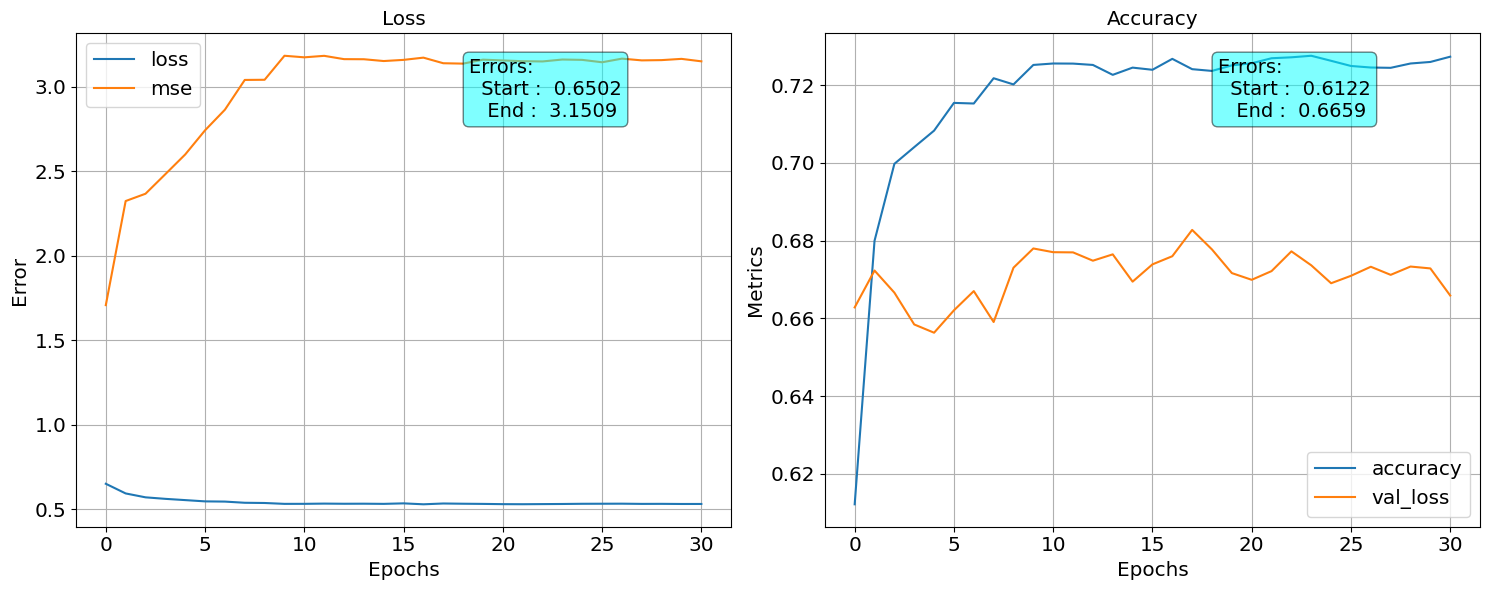

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

l_range = 50

ax = axes[0]
y1 = loss_df.columns[0]
y2 = loss_df.columns[2]

loss_df.plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot


# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title(y1.capitalize())
ax.grid();

ax = axes[1]

y1 = loss_df.columns[1]
y2 = loss_df.columns[3]
loss_df.plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.set_title(y1.capitalize())
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['val_loss']== loss_df['val_loss'].min()]

,loss,accuracy,mse,val_loss,val_accuracy,val_mse,lr
4,0.553468,0.708276,2.599621,0.656305,0.695023,2.121817,0.001


In [ ]:
loss_df[loss_df['val_accuracy']== loss_df['val_accuracy'].max()]

,loss,accuracy,mse,val_loss,val_accuracy,val_mse,lr
19,0.531009,0.725066,3.16077,0.671639,0.70627,2.619853,1.000000e-09


In [81]:
X_train.shape , y_train.shape

((37700, 26), (37700,))